# COSC 3337 - Group Project
### Spencer Ennadi-Johnson : 1597600 
### Heer Loungani : 2173441 
### Vitor Santos : 2234870 

# Data Preprocessing

### Dataset Stats -> dataset_quality_report.csv :
- invalid records with empty attributes, duplicate records, or incorrect hyphenations

In [1]:
import pandas as pd
import re
from collections import defaultdict
from io import StringIO

# --------------------------------------------
# Rules
# --------------------------------------------
HYPH_REGEX = r"[A-Za-z]-\s+(?!and\b|a\b|und\b|or\b)[a-z]"
hyphenation_re = re.compile(HYPH_REGEX)


# --------------------------------------------
# Chunked reader for JSONL
# --------------------------------------------
def read_jsonl_chunks(path, chunksize=100_000):
    batch = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            batch.append(line.rstrip("\n"))
            if (i + 1) % chunksize == 0:
                json_text = "[{}]".format(",".join(batch))
                yield pd.read_json(StringIO(json_text))
                batch = []
        if batch:
            json_text = "[{}]".format(",".join(batch))
            yield pd.read_json(StringIO(json_text))


# --------------------------------------------
# Fast profiling + EXAMPLES collection (NEW)
# --------------------------------------------
def profile_chunk(df, seen_ids, seen_rows_hashes, examples):
    stats = defaultdict(int)

    # ----------------------------------------
    # EMPTY FIELDS
    # ----------------------------------------
    if "authors" in df:
        mask = df["authors"].map(lambda x: len(x) == 0 if isinstance(x, list) else False)
        stats["empty_authors"] += mask.sum()

    if "references" in df:
        mask = df["references"].map(lambda x: len(x) == 0 if isinstance(x, list) else False)
        stats["empty_references"] += mask.sum()

    # string columns
    for col in ["title", "venue", "abstract"]:
        if col in df:
            mask = (
                df[col].isna() |
                df[col].eq("") |
                df[col].eq("NaN")
            )
            stats[f"empty_{col}"] += mask.sum()

    # numeric fields
    for col in ["year", "n_citation"]:
        if col in df:
            mask = df[col].isna()
            stats[f"empty_{col}"] += mask.sum()

    # ----------------------------------------
    # HYPHENATION
    # ----------------------------------------
    for col in ["title", "venue", "abstract"]:
        if col in df:
            mask = df[col].astype(str).str.contains(HYPH_REGEX, regex=True, na=False)
            stats[f"hyph_{col}"] += mask.sum()

            for v in df.loc[mask, col].head(5 - len(examples[f"hyph_{col}"])):
                if len(examples[f"hyph_{col}"]) < 5:
                    examples[f"hyph_{col}"].append(v)

    # ----------------------------------------
    # DUPLICATE IDS (GLOBAL)
    # ----------------------------------------
    if "id" in df:
        for val in df["id"].astype(str):
            if val in seen_ids:
                stats["duplicate_ids"] += 1
            else:
                seen_ids.add(val)

    # ----------------------------------------
    # DUPLICATE FULL ROWS (GLOBAL)
    # ----------------------------------------
    df_for_dupes = df.copy()
    for col in df_for_dupes.columns:
        if df_for_dupes[col].apply(lambda x: isinstance(x, list)).any():
            df_for_dupes[col] = df_for_dupes[col].astype(str)

    row_hashes = df_for_dupes.astype(str).agg('|'.join, axis=1)

    for h in row_hashes:
        if h in seen_rows_hashes:
            stats["duplicate_rows"] += 1
        else:
            seen_rows_hashes.add(h)

    stats["rows"] += len(df)
    return stats


# --------------------------------------------
# Profile entire file
# --------------------------------------------
def profile_file(path, examples):
    totals = defaultdict(int)
    seen_ids = set()
    seen_rows_hashes = set()

    for chunk in read_jsonl_chunks(path):
        chunk_stats = profile_chunk(chunk, seen_ids, seen_rows_hashes, examples)
        for k, v in chunk_stats.items():
            totals[k] += v

    return totals


# --------------------------------------------
# Summary for multiple files
# --------------------------------------------
def profile_files(jsonl_files):
    report_rows = []

    # storage for examples across ALL files
    examples = defaultdict(list)

    for file in jsonl_files:
        print(f"Processing {file} ...")

        totals = profile_file(file, examples)

        row = {
            "file": file,
            "rows_total": totals["rows"],
            "duplicate_rows": totals["duplicate_rows"],
            "duplicate_ids": totals["duplicate_ids"],
        }

        for col in ["authors", "references", "title", "venue", "abstract", "year", "n_citation"]:
            row[f"empty_{col}"] = totals.get(f"empty_{col}", 0)
            row[f"hyphen_{col}"] = totals.get(f"hyph_{col}", 0)

        report_rows.append(row)

    return pd.DataFrame(report_rows), examples


# --------------------------------------------
# Run
# --------------------------------------------
files = [
    "dblp-ref-0.json",
    "dblp-ref-1.json",
    "dblp-ref-2.json",
    "dblp-ref-3.json"
]

summary_report, examples = profile_files(files)
summary_report.to_csv("dataset_quality_report.csv", index=False)
print(summary_report)
print("\nEXAMPLES OF INVALID DATA:")
for k, v in examples.items():
    print(f"\n{k}:")
    for ex in v:
        print("  -", ex)


Processing dblp-ref-0.json ...
Processing dblp-ref-1.json ...
Processing dblp-ref-2.json ...
Processing dblp-ref-3.json ...
              file  rows_total  duplicate_rows  duplicate_ids  empty_authors  \
0  dblp-ref-0.json     1000000               0              0              0   
1  dblp-ref-1.json     1000000               0              0              0   
2  dblp-ref-2.json     1000000               0              0              0   
3  dblp-ref-3.json       79007               0              0              0   

   hyphen_authors  empty_references  hyphen_references  empty_title  \
0               0             70708                  0            0   
1               0             82388                  0            0   
2               0             56395                  0            0   
3               0              2528                  0            0   

   hyphen_title  empty_venue  hyphen_venue  empty_abstract  hyphen_abstract  \
0           298       210500            

### Clean Dataset -> dblp-validated-00-17.json :
- remove duplicates, records with empty required features
- correct hyphenation
- apply year filter (2000 through 2017)

### Provide Stats on Intermediate Dataset

Processing dblp-ref-0.json ...
Processing dblp-ref-1.json ...
Processing dblp-ref-2.json ...
Processing dblp-ref-3.json ...

Done. Cleaned dataset written to:
dblp-validated-00-17.json

Total records: 1765554
Unique venues: 4168


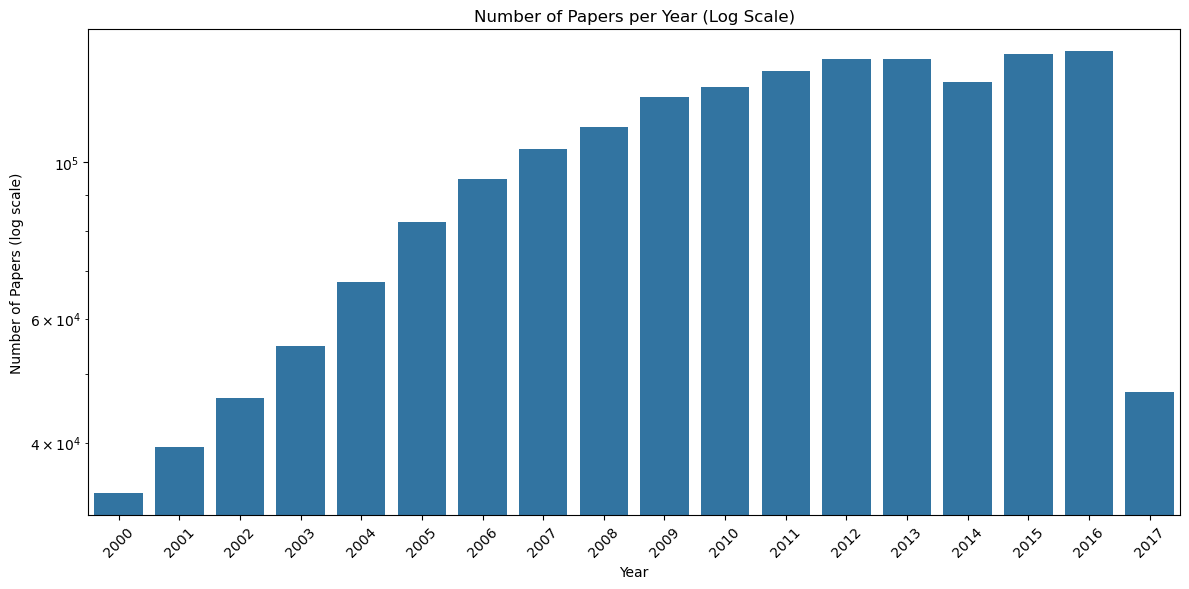

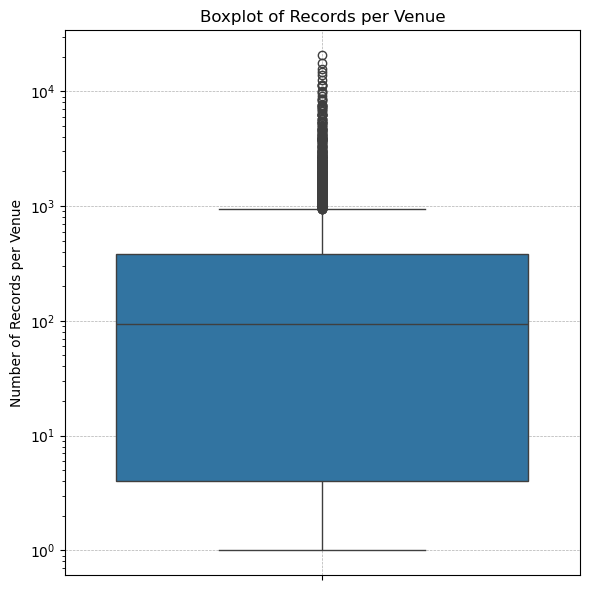

Venue stats:
Q1 = 4.0, Q3 = 380.25, IQR = 376.25
Upper fence = 944.625, Upper whisker = 944


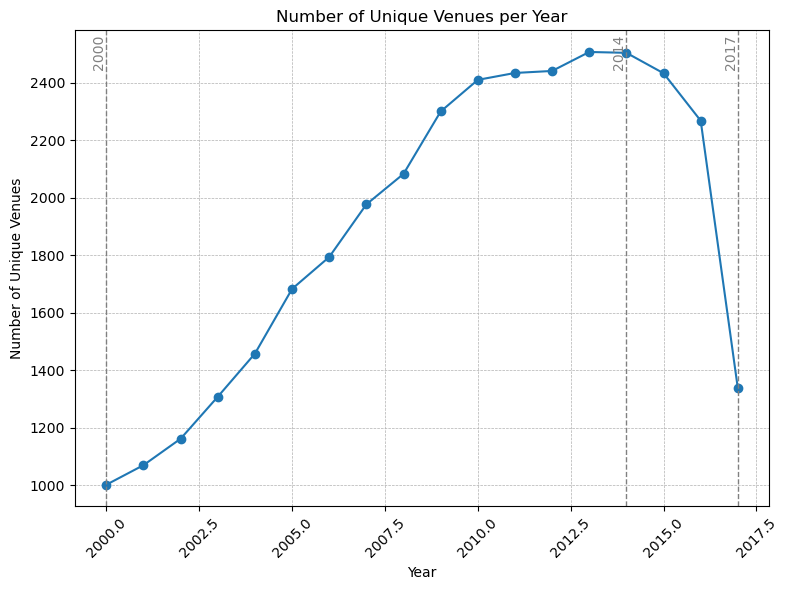

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from io import StringIO
from collections import defaultdict

# Required fields
REQUIRED_LIST_FIELDS = ["authors", "references"]
REQUIRED_STR_FIELDS = ["title", "venue", "abstract"]  # venue now also gets hyphen fixes

# Hyphenation detection regex
HYPH_REGEX = r"[A-Za-z]-\s+(?!and\b|a\b|und\b|or\b)[a-z]"
HYPH_FIX_REGEX = re.compile(r"([A-Za-z])- (\b(?!and\b|a\b|und\b|or\b)[a-z])")  # lowercase follow only

# --------------------------------------------
# Chunked JSONL reader
# --------------------------------------------
def read_jsonl_chunks(path, chunksize=100_000):
    batch = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            batch.append(line.rstrip("\n"))
            if (i + 1) % chunksize == 0:
                yield pd.read_json(StringIO("[" + ",".join(batch) + "]"))
                batch = []
        if batch:
            yield pd.read_json(StringIO("[" + ",".join(batch) + "]"))

# --------------------------------------------
# Fix hyphenation
# --------------------------------------------
def fix_hyphenation_series(series):
    return series.where(
        series.isna(),
        series.astype(str).str.replace(HYPH_FIX_REGEX, r"\1\2", regex=True)
    )

# --------------------------------------------
# Clean a single chunk + compute stats
# --------------------------------------------
def clean_chunk(df, seen_ids, stats):
    df = df.copy()

    # Filter year range (2000-2017)
    if "year" in df:
        df = df[pd.to_numeric(df["year"], errors="coerce").between(2000, 2017)]

    # Fix hyphenation
    for col in ["title", "abstract", "venue"]:
        if col in df:
            df[col] = fix_hyphenation_series(df[col])

    # Remove empty list fields
    for col in REQUIRED_LIST_FIELDS:
        if col in df:
            df = df[df[col].map(lambda x: isinstance(x, list) and len(x) > 0)]

    # Remove empty string fields
    for col in REQUIRED_STR_FIELDS:
        if col in df:
            df = df[~df[col].isna()]
            df = df[~df[col].eq("") & ~df[col].eq("NaN")]

    # Deduplicate IDs
    if "id" in df:
        id_series = df["id"].astype(str)
        dup_mask = id_series.isin(seen_ids)
        if dup_mask.any():
            df = df[~dup_mask]
        seen_ids.update(df["id"].astype(str).tolist())

    # --------------------------------------------
    # Update stats during cleaning
    # --------------------------------------------
    stats["total_records"] += len(df)

    if "venue" in df:
        venues = df["venue"].dropna()
        stats["unique_venues"].update(venues.unique())
        for v in venues:
            stats["venue_counts"][v] += 1

    if "year" in df:
        years = df["year"].dropna()
        stats["unique_years"].update(years.unique())
        for y in years:
            stats["year_counts"][y] += 1

    # Venues per year
    if "year" in df and "venue" in df:
        for y, v in zip(df["year"], df["venue"]):
            if pd.notna(y) and pd.notna(v):
                stats["venues_per_year"][y].add(v)

    return df

# --------------------------------------------
# Clean multiple files into ONE file and collect stats
# --------------------------------------------
def clean_files_to_one(input_files, output_file, chunksize=100_000):
    seen_ids = set()
    stats = {
        "total_records": 0,
        "unique_venues": set(),
        "unique_years": set(),
        "year_counts": defaultdict(int),
        "venue_counts": defaultdict(int),
        "venues_per_year": defaultdict(set)
    }

    with open(output_file, "w", encoding="utf-8") as fout:
        for input_path in input_files:
            print(f"Processing {input_path} ...")
            for chunk in read_jsonl_chunks(input_path, chunksize=chunksize):
                cleaned_chunk = clean_chunk(chunk, seen_ids, stats)
                if len(cleaned_chunk) == 0:
                    continue

                for record in cleaned_chunk.to_dict(orient="records"):
                    fout.write(json.dumps(record) + "\n")

    print(f"\nDone. Cleaned dataset written to:\n{output_file}")

    # Convert venue sets to counts per year
    stats["venues_count_per_year"] = {y: len(vs) for y, vs in stats["venues_per_year"].items()}
    return stats

# --------------------------------------------
# Example run
# --------------------------------------------
if __name__ == "__main__":
    input_files = [
        "dblp-ref-0.json",
        "dblp-ref-1.json",
        "dblp-ref-2.json",
        "dblp-ref-3.json"
    ]
    output_file = "dblp-validated-00-17.json"

    stats = clean_files_to_one(input_files, output_file)

    # Convert stats sets to sorted lists for printing/plotting
    stats["unique_venues"] = sorted(stats["unique_venues"])
    stats["unique_years"] = sorted(stats["unique_years"])
    
    print(f"\nTotal records: {stats['total_records']}")
    print(f"Unique venues: {len(stats['unique_venues'])}")
    # -------------------------------
    # Records per year (log scale)
    # -------------------------------
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(stats['year_counts'].keys()), y=list(stats['year_counts'].values()))
    plt.yscale('log')
    plt.xticks(rotation=45)
    plt.xlabel("Year")
    plt.ylabel("Number of Papers (log scale)")
    plt.title("Number of Papers per Year (Log Scale)")
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # Records per venue (boxplot)
    # -------------------------------
    venue_counts_list = list(stats['venue_counts'].values())
    plt.figure(figsize=(6, 6))
    sns.boxplot(y=venue_counts_list)
    plt.yscale('log')
    plt.ylabel("Number of Records per Venue")
    plt.title("Boxplot of Records per Venue")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Compute Tukey's upper whisker
    vc = np.array(venue_counts_list)
    Q1 = np.percentile(vc, 25)
    Q3 = np.percentile(vc, 75)
    IQR = Q3 - Q1
    upper_fence = Q3 + 1.5 * IQR
    upper_whisker = vc[vc <= upper_fence].max()

    print("Venue stats:")
    print(f"Q1 = {Q1}, Q3 = {Q3}, IQR = {IQR}")
    print(f"Upper fence = {upper_fence}, Upper whisker = {upper_whisker}")

    # -------------------------------
    # Venues per year (line plot + vertical markers)
    # -------------------------------
    years_sorted = sorted(stats['venues_count_per_year'].keys())
    values_sorted = [stats['venues_count_per_year'][y] for y in years_sorted]

    plt.figure(figsize=(8, 6))
    plt.plot(years_sorted, values_sorted, marker='o', linestyle='-')

    milestones = [2000, 2014, 2017]
    for yr in milestones:
        plt.axvline(x=yr, color='gray', linestyle='--', linewidth=1)
        plt.text(yr, max(values_sorted), str(yr),
                 rotation=90, va='center', ha='right', color='gray')

    plt.xlabel("Year")
    plt.ylabel("Number of Unique Venues")
    plt.title("Number of Unique Venues per Year")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


### Remove venues under 1k and separate by (2000-2014) and (2015-2017)
- dblp-venues-over-1k-00-14.json
- dblp-venues-over-1k-15-17.json

In [3]:
import json
import pandas as pd
from collections import defaultdict
from io import StringIO


# --------------------------------------------
# Chunked JSONL reader
# --------------------------------------------
def read_jsonl_chunks(path, chunksize=100_000):
    batch = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            batch.append(line.rstrip("\n"))
            if (i + 1) % chunksize == 0:
                json_text = "[" + ",".join(batch) + "]"
                yield pd.read_json(StringIO(json_text))
                batch = []
        if batch:
            json_text = "[" + ",".join(batch) + "]"
            yield pd.read_json(StringIO(json_text))


# --------------------------------------------------------------------
# PASS 1 — Count venue frequencies
# --------------------------------------------------------------------
def compute_venue_counts(path, chunksize=100_000):
    venue_counts = defaultdict(int)

    print(f"Counting venues in {path} ...")

    for chunk in read_jsonl_chunks(path, chunksize=chunksize):
        if "venue" in chunk:
            for v in chunk["venue"].dropna():
                venue_counts[v] += 1

    print("Done counting venue frequencies.")
    return venue_counts


# --------------------------------------------------------------------
# PASS 2 — Filter venues >= threshold AND split by year ranges
# --------------------------------------------------------------------
def filter_and_split_by_year(
    path, 
    venue_counts, 
    min_count=1000, 
    chunksize=100_000,
    out_2000_2014="dblp-venues-over-1k-00-14.json",
    out_2015_2017="dblp-venues-over-1k-15-17.json"
):

    # Open both output files
    f1 = open(out_2000_2014, "w", encoding="utf-8")
    f2 = open(out_2015_2017, "w", encoding="utf-8")

    print(f"Filtering papers in {path} and splitting by year...")

    for chunk in read_jsonl_chunks(path, chunksize=chunksize):

        if "venue" not in chunk or "year" not in chunk:
            continue

        # Filter by venue strength
        mask = chunk["venue"].map(lambda v: venue_counts.get(v, 0) >= min_count)
        filtered = chunk[mask]

        # Write to the correct file based on year
        for _, row in filtered.iterrows():
            y = row["year"]
            if pd.isna(y):
                continue

            rec = json.dumps(row.to_dict())

            if 2000 <= y <= 2014:
                f1.write(rec + "\n")
            elif 2015 <= y <= 2017:
                f2.write(rec + "\n")

    f1.close()
    f2.close()

    print("\nDone. Datasets written to:")
    print(f" → {out_2000_2014}")
    print(f" → {out_2015_2017}")


# --------------------------------------------------------------------
# RUN PIPELINE
# --------------------------------------------------------------------
if __name__ == "__main__":

    input_file = "dblp-validated-00-17.json"

    # Output files (you can rename freely)
    out_early = "dblp-venues-over-1k-00-14.json"
    out_late  = "dblp-venues-over-1k-15-17.json"

    # PASS 1: venue counts
    venue_counts = compute_venue_counts(input_file)

    # PASS 2: venue filter + year split output
    filter_and_split_by_year(
        input_file,
        venue_counts,
        min_count=1000,
        out_2000_2014=out_early,
        out_2015_2017=out_late
    )


Counting venues in dblp-validated-00-17.json ...
Done counting venue frequencies.
Filtering papers in dblp-validated-00-17.json and splitting by year...

Done. Datasets written to:
 → dblp-venues-over-1k-00-14.json
 → dblp-venues-over-1k-15-17.json


# Feature Engineering and Temporal Classification
This section constructs time-aware venue and author features and trains a temporal model
to predict high-impact papers using data from 2000–2014, then evaluates on 2015–2017.

In [ ]:
import pandas as pd

# Load training and test sets
train_path = "dblp-venues-over-1k-00-14.json"
test_path = "dblp-venues-over-1k-15-17.json"

df_train = pd.read_json(train_path, lines=True)
df_test = pd.read_json(test_path, lines=True)

df_train["split"] = "train"
df_test["split"]  = "test"

Basic Numeric Feature Engineering to compute simple document and metadata features

In [2]:
for df in [df_train, df_test]:
    df["abstract_length_words"] = df["abstract"].str.split().str.len()
    df["num_authors"] = df["authors"].apply(len)
    df["num_references"] = df["references"].apply(len)

Merge Train and Test datasets to compute cumulative venue and author statistics without leakage

In [3]:
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all = df_all.sort_values("year")

Compute Venue Prestige (Cumulative Up to Previous Year)

In [4]:
venue_year = (
    df_all.groupby(["venue","year"])
    .agg(
        venue_year_n_papers=("id","count"),
        venue_year_total_citations=("n_citation","sum")
    ).reset_index()
)

venue_year = venue_year.sort_values(["venue","year"])
venue_year["venue_cum_papers"]     = venue_year.groupby("venue")["venue_year_n_papers"].cumsum()
venue_year["venue_cum_citations"]  = venue_year.groupby("venue")["venue_year_total_citations"].cumsum()
venue_year["venue_cum_mean"]       = venue_year["venue_cum_citations"] / venue_year["venue_cum_papers"]

venue_year["venue_cum_papers_past"]    = venue_year.groupby("venue")["venue_cum_papers"].shift(1)
venue_year["venue_cum_citations_past"] = venue_year.groupby("venue")["venue_cum_citations"].shift(1)
venue_year["venue_cum_mean_past"]      = venue_year.groupby("venue")["venue_cum_mean"].shift(1)

df_all = df_all.merge(
    venue_year[[
        "venue","year",
        "venue_cum_papers_past","venue_cum_citations_past","venue_cum_mean_past"
    ]],
    on=["venue","year"],
    how="left"
)


Compute Author Reputation (Cumulative Up to Previous Year)

In [5]:
authors_long = (
    df_all[["id","year","n_citation","authors"]]
    .explode("authors")
    .rename(columns={"authors":"author"})
)

author_year = (
    authors_long.groupby(["author","year"])
    .agg(
        author_year_n_papers=("id","count"),
        author_year_total_citations=("n_citation","sum")
    ).reset_index()
)

author_year = author_year.sort_values(["author","year"])
author_year["author_cum_papers"]    = author_year.groupby("author")["author_year_n_papers"].cumsum()
author_year["author_cum_citations"] = author_year.groupby("author")["author_year_total_citations"].cumsum()
author_year["author_cum_mean"]      = author_year["author_cum_citations"] / author_year["author_cum_papers"]

author_year["author_cum_papers_past"]    = author_year.groupby("author")["author_cum_papers"].shift(1)
author_year["author_cum_citations_past"] = author_year.groupby("author")["author_cum_citations"].shift(1)
author_year["author_cum_mean_past"]      = author_year.groupby("author")["author_cum_mean"].shift(1)

authors_long = authors_long.merge(
    author_year[[
        "author","year",
        "author_cum_papers_past","author_cum_citations_past","author_cum_mean_past"
    ]],
    on=["author","year"],
    how="left"
)

author_rep = (
    authors_long.groupby("id")
    .agg(
        author_past_papers_sum=("author_cum_papers_past","sum"),
        author_past_citations_sum=("author_cum_citations_past","sum"),
        author_past_mean_citations_mean=("author_cum_mean_past","mean"),
        author_past_mean_citations_max=("author_cum_mean_past","max")
    )
    .reset_index()
)

df_all = df_all.merge(author_rep, on="id", how="left")
df_all = df_all.loc[:, ~df_all.columns.duplicated()]


Restore Clean Train/Test Splits and recover temporal splits after time-dependent feature engineering

In [6]:
df_train = df_all[df_all["split"]=="train"].copy()
df_test  = df_all[df_all["split"]=="test"].copy()

Recompute High-Impact Labels (Top 10% Citations Per Year), labels are recomputed AFTER merging to avoid losing 'high_impact'

In [7]:
# training labels
train_thresh = df_train.groupby("year")["n_citation"].quantile(0.9)
df_train = df_train.merge(train_thresh.rename("year_threshold"), on="year", how="left")
df_train["high_impact"] = (df_train["n_citation"] >= df_train["year_threshold"]).astype(int)

# testing labels
test_thresh = df_test.groupby("year")["n_citation"].quantile(0.9)
df_test = df_test.merge(test_thresh.rename("year_threshold"), on="year", how="left")
df_test["high_impact"] = (df_test["n_citation"] >= df_test["year_threshold"]).astype(int)

TF-IDF Text Features to convert paper abstracts into TF-IDF vectors

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_text_train = tfidf.fit_transform(df_train["abstract"])
X_text_test  = tfidf.transform(df_test["abstract"])

Numeric Feature Matrix to scale features for smooth optimization

In [9]:
num_features = [
    "abstract_length_words","num_authors","num_references",
    "venue_cum_papers_past","venue_cum_citations_past","venue_cum_mean_past",
    "author_past_papers_sum","author_past_citations_sum",
    "author_past_mean_citations_mean","author_past_mean_citations_max"
]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_num_train = scaler.fit_transform(df_train[num_features].fillna(0))
X_num_test  = scaler.transform(df_test[num_features].fillna(0))


Combine text and numeric features to construct full model input matrices

In [10]:
from scipy.sparse import hstack

X_train = hstack([X_text_train, X_num_train])
X_test  = hstack([X_text_test,  X_num_test])

y_train = df_train["high_impact"].values
y_test  = df_test["high_impact"].values


Train Logistic Regression Model to train validation split and initial performance check


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1)
log_reg.fit(X_tr, y_tr)

print(classification_report(y_val, log_reg.predict(X_val), digits=3))


              precision    recall  f1-score   support

           0      0.899     0.710     0.793    145687
           1      0.341     0.653     0.448     33429

    accuracy                          0.699    179116
   macro avg      0.620     0.681     0.621    179116
weighted avg      0.795     0.699     0.729    179116



Evaluate on Future Papers (2015-2017), temporal generalization test on unseen future years

In [12]:
y_test_pred = log_reg.predict(X_test)
y_test_prob = log_reg.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.885     0.374     0.526    186038
           1      0.188     0.749     0.300     35970

    accuracy                          0.435    222008
   macro avg      0.537     0.562     0.413    222008
weighted avg      0.772     0.435     0.489    222008



Confusion matrix for visual inspection of prediction distribution

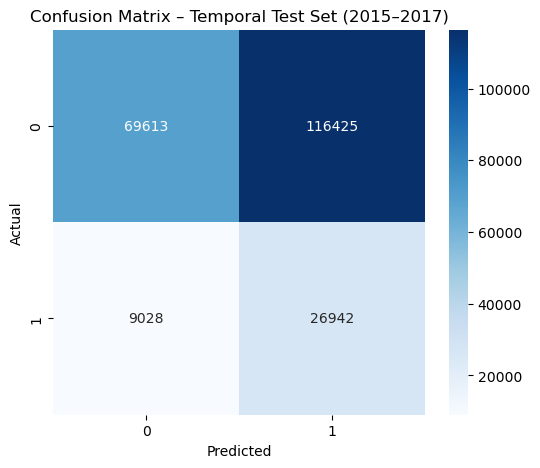

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix – Temporal Test Set (2015–2017)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


ROC Curve showA model discriminatiVE ability.

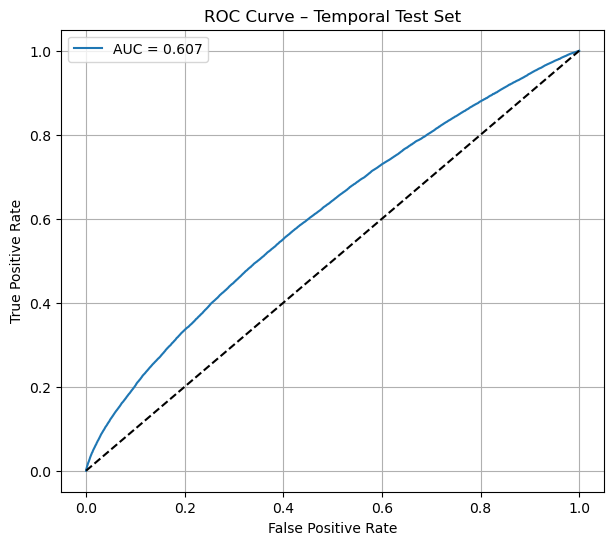

In [14]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Temporal Test Set")
plt.legend()
plt.grid(True)
plt.show()


Precision–Recall Curve is useful due to class imbalance.

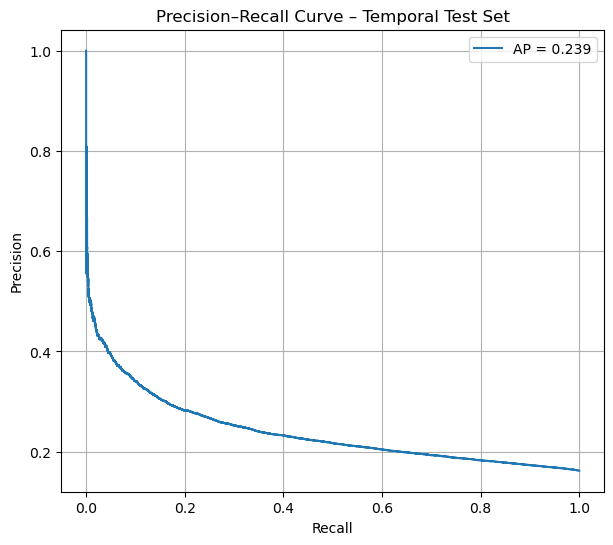

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
ap = average_precision_score(y_test, y_test_prob)

plt.figure(figsize=(7,6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Temporal Test Set")
plt.legend()
plt.grid(True)
plt.show()


Residual Distribution (For Anomaly Detection)


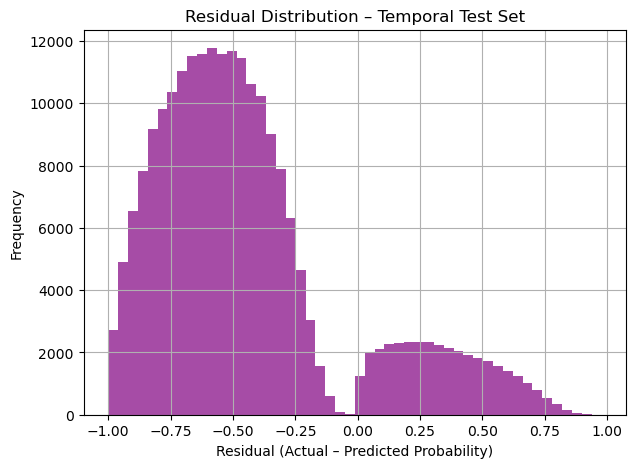

In [16]:
df_test["residual"] = df_test["high_impact"] - y_test_prob

plt.figure(figsize=(7,5))
plt.hist(df_test["residual"], bins=50, color="purple", alpha=0.7)
plt.xlabel("Residual (Actual – Predicted Probability)")
plt.ylabel("Frequency")
plt.title("Residual Distribution – Temporal Test Set")
plt.grid(True)
plt.show()


Save Model Prediction

In [17]:
df_test["predicted_prob"] = y_test_prob
df_test["predicted_label"] = y_test_pred

df_test.to_parquet("temporal_predictions_2015_2017.parquet")
df_test.head()

,abstract,authors,n_citation,references,title,venue,year,id,split,abstract_length_words,...,venue_cum_mean_past,author_past_papers_sum,author_past_citations_sum,author_past_mean_citations_mean,author_past_mean_citations_max,year_threshold,high_impact,residual,predicted_prob,predicted_label
0,This paper presents the first published fully-...,"[Christian Venerus, Ian Galton]",11,"[01ac5fce-6a7a-483c-b76a-8a5b49b1572b, 0dd0d0d...",A TDC-Free Mostly-Digital FDC-PLL Frequency Sy...,IEEE Journal of Solid-state Circuits,2015,e8595565-6be4-4047-bb31-4f22f77bd35e,test,216,...,46.505576,21.0,596.0,18.815789,30.631579,50.0,0,-0.708105,0.708105,1
1,We present a novel approach to separating pitc...,[Miroslav Zivanovic],0,"[00b47001-3db4-4101-8080-eaf0adfc5dac, 03e2ca5...",Harmonic bandwidth companding for separation o...,"IEEE Transactions on Audio, Speech, and Langua...",2015,e85e3089-dfd2-449b-b734-5e5e2dd5b68d,test,140,...,61.489227,7.0,213.0,30.428571,30.428571,50.0,0,-0.623174,0.623174,1
2,Intermittent high intensity ultrasound pulses ...,"[Yiying I. Zhu, Douglas L. Miller, Chunyan Dou...",50,"[2df9bdf8-4333-4f02-a81f-c6420da1c216, f5ba7b8...",Characterization of Macrolesions Induced by My...,IEEE Transactions on Biomedical Engineering,2015,e85cda7e-052f-48f7-9502-2fe78a4b3e14,test,249,...,61.704803,1.0,3.0,3.000000,3.000000,50.0,1,0.574779,0.425221,0
3,This paper presents a spectrum monitoring algo...,"[Abdelmohsen Ali, Walaa Hamouda]",19,"[0fd91b1b-8d09-4be9-b372-cdbf17c21037, 20fbecb...",Spectrum Monitoring Using Energy Ratio Algorit...,IEEE Transactions on Wireless Communications,2015,e8618c39-6ccf-4db8-bdf4-557138b11ccf,test,170,...,66.770465,86.0,2290.0,26.627907,26.627907,50.0,0,-0.709737,0.709737,1
4,We investigate a parameter plane of a set of t...,"[Rodrigo A. da Silva, Paulo C. Rech]",1,"[000721ca-1d0a-428a-82fb-a491cc551e38, 18755d2...",Spiral periodic structures in a parameter plan...,Applied Mathematics and Computation,2015,e85a6433-2417-4287-a5b7-df4af3053ebd,test,76,...,28.868451,12.0,114.0,9.500000,9.500000,50.0,0,-0.444707,0.444707,0


# Anomaly Detection and Topic Drift